In [42]:
pip install -q konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 63.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 13.5 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [46]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x78e789ba43d0>)

In [6]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [7]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [10]:
train_data.head() # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [11]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [12]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [13]:
# document 열과 label 열의 중복을 제외한 값의 개수 
train_data['document'].nunique(), train_data['label'].nunique() #number unique 유니크 숫자

(146182, 2)

In [14]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [15]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: xlabel='label'>

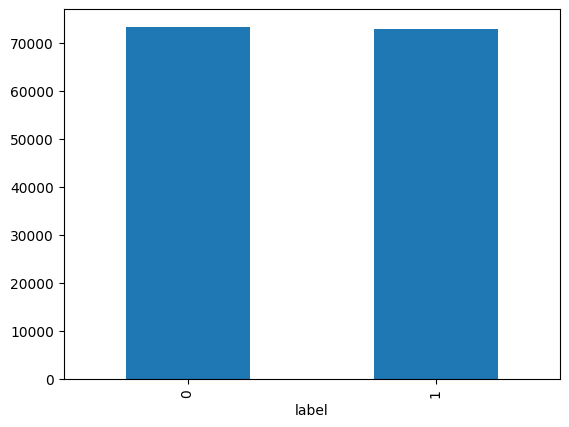

In [16]:
train_data['label'].value_counts().plot(kind = 'bar')

In [19]:
train_data.groupby('label').size()

label
0    73342
1    72841
dtype: int64

In [20]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [21]:
print(train_data.isnull().values.any())

True


In [22]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [23]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [24]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [25]:
print(len(train_data))

146182


In [26]:
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))  
#re.sub(r'[^a-zA-Z ]  [^a-zA-Z ]: 소문자, 대문자, 공백이 아닌 모든 문자에 매칭.
#'': 매칭된 문자를 빈 문자열로 대체 → 제거.
#결과적으로 알파벳과 공백만 남게 됨.

do you expect people to read the FAQ etc and actually accept hard atheism


In [28]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) #한글만 남기고 다 없앤다.
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [29]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())   #'^ +' 공백이 여러개 있다. 

id            0
document    789
label         0
dtype: int64


<ipython-input-29-59a2387a36e3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)


In [30]:
train_data.loc[train_data.document.isnull()][:5] #loc(조건에 속하는 것들 찾는다.)[train_data.document.isnull()]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [31]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [32]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-32-59211301370a>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


In [33]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
#중요하지 않다고 생각 되는거 뺀다.

In [43]:
from konlpy.tag import Okt

In [44]:
mecab = Okt()
mecab.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [47]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [07:02<00:00, 344.40it/s]


In [48]:
print(X_train[:3])


[['아', '더빙', '진짜', '짜증나네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'], ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천']]


In [49]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [02:33<00:00, 317.86it/s]


In [50]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)


In [51]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')


--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


In [52]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))


총 단어수 : 88276


In [53]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])


훈련 데이터에서의 단어 영화의 등장 횟수 : 40264
훈련 데이터에서의 단어 공감의 등장 횟수 : 784


In [54]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])


등장 빈도수 상위 10개 단어
['영화', '너무', '정말', '만', '적', '진짜', '으로', '로', '점', '에서']


In [56]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 88276
등장 빈도가 2번 이하인 희귀 단어의 수: 60078
단어 집합에서 희귀 단어의 비율: 68.05700303593277
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.644509532507002


In [57]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))


단어 집합의 크기 : 28198


In [58]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))


단어 집합의 크기 : 28198


In [61]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1


In [62]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2


In [63]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)


패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 28200


In [64]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])


단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


##정수 인코딩

In [65]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data


In [66]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)


In [67]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)


[373, 2422, 7023, 16429]
[9560, 3697, 75, 2346, 544, 24, 1, 615]


In [68]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key


In [69]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)


기존의 첫번째 샘플 : ['이야', '어쩜', '이렇게나', '지루할수가']
복원된 첫번째 샘플 : ['이야', '어쩜', '이렇게나', '지루할수가']


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.925228261430266


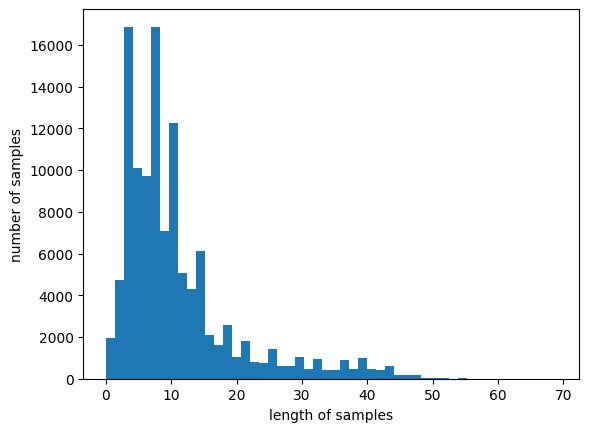

In [70]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [71]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [72]:
max_len = 30
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.11850680055711


In [74]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)


In [76]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 30
첫번째 샘플 : [  373  2422  7023 16429     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [78]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [79]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([0, 1, 1, 1, 1])


In [80]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits


In [81]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)


In [82]:
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))


총 배치의 수 : 3635


In [83]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)


TextClassifier(
  (embedding): Embedding(28200, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)